In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
import os
import time

### Define a function to fetch MAST data from TESScut via cURL command.

In [2]:
mast_data_path = '/Users/waderoemer/Desktop/MScThesis/MAST_data'

def get_mast_data(ra,dec):
    curl_cmd = f'curl -O "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=5&x=5"'
    #fetch the data from MAST using a cURL command
    os.system('cd MAST_data\n' + curl_cmd)
    
    #append '.zip' to the filename, otherwise the computer doesn't know how to handle the file
    os.system(f'mv {mast_data_path}/astrocut\?ra={ra}\&dec={dec}\&y=5\&x=5 {mast_data_path}/astrocut\?ra={ra}\&dec={dec}\&y=5\&x=5.zip')
    time.sleep(3) # let's try not to get blacklist by MAST... 


def decompress_mast_data(ra,dec):
    #decompress the .zip file
    os.system(f'open {mast_data_path}/astrocut\?ra={ra}\&dec={dec}\&y=5\&x=5.zip')
    time.sleep(10) #need time for decompression, or else the line below will delete it before it's done
    
    #delete the original .zip file
    os.system(f'rm {mast_data_path}/astrocut\?ra={ra}\&dec={dec}\&y=5\&x=5.zip')

#### Loop over all source positions in the KiDS catalog.
#### NOTE: If you run this cell, you will download ~2000 files to your machine.

In [ ]:
kids_data = pd.read_csv('KiDS_lenses.csv',skiprows=7)

# need to add if os.exists(path) since we already fetched some of the data
#for i in range(len(kids_data)): # just uncomment this to get the data
    ra = kids_data['RA'][i]
    dec = kids_data['DEC'][i]
    get_mast_data(ra,dec)

### Define functions to generate the integrated FFI image, a string describing the source, and the QA plot.

In [162]:
def integrate_ffi_stack(hdu):
    data = hdu[1].data
    # find the sum for each pixel, output as an array with the same shape
    
    image_sum = np.zeros(shape=(5,5))
    for i in range(len(flux)):
        frame = flux[i]
        image_sum = np.add(image_sum,flux[i])
    
    # find the average for each pixel, output as an array with the same shape
    image_avg = np.mean(data['FLUX']) #nope, need to find avg of EACH pixel (yay!)
    integrated_image = image_sum/image_avg

    return integrated_image

In [176]:
def create_source_str(hdu):
    sector = str(hdu['PRIMARY'].header['SECTOR'])
    ra = # extract center pixel skypos
    dec = # same ^
    disc_rating = # from KiDS data
    
    source_str = f'''
                    TESS Sector:{sector} \n
                    Sky position [deg]: {ra} , {dec} \n
                    DISC Rating: {disc_rating}
                '''
    return source_str

kids_data = pd.read_csv('KiDS_lenses.csv',skiprows=7)

SyntaxError: invalid syntax (<ipython-input-176-93c74755f5ff>, line 3)

In [185]:
def make_qa_plot(filepath):
    
    #generate the integrated image and define WCS
    hdu = fits.open(filepath)
    data = hdu[1].data
    integrated_image = integrate_ffi_stack(hdu)
    
    #produce the flux array for the center pixel (flux values are in nested arrays bc it is a 5x5 pixel .fits)
    flux = []
    for i in range(len(data['FLUX'])):
        flux_i = data['FLUX'][i][2][2]
        flux.append(flux_i)
    
    
    fig = plt.figure(figsize=(12,8),tight_layout=True)
    gs = fig.add_gridspec(2, 3)
    
    #plot integrated image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(integrated_image, origin = 'lower', cmap = plt.cm.viridis) # origin? keep viridis cm? **
    #ax1.colorbar(fraction = 0.046) # do we even need this?
    wcs = WCS(hdu[2].header)
    #fig.add_subplot(111, projection=wcs) #figure out how to make this work (or do we even need it...?)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xticks([])
    plt.xlabel('RA', fontsize = 14)
    plt.ylabel('Dec',fontsize = 14)
    
    #plot text box of source info.
    ax2 = fig.add_subplot(gs[0,1:])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.text(0.5,0.5,'Test',fontsize=20)
    for pos in ['top','bottom','left','right']: # do we like without the spine, or should we stylize instead?
        ax2.spines[pos].set_color('white') # this might look better with thick (rounded edge?) spines
    
    #plot LC
    ax3 = fig.add_subplot(gs[1,0:])
    t = data['TIME']
    ax3.plot(t,flux,'b-') # ** do we have errors on these flux values ?? --> Check! **
    ax3.set_xlabel('Time [days]', fontsize = 14)
    ax3.set_ylabel('Flux [e-/s]', fontsize = 14)
    # add top xlabel

In [186]:
#adjustments to make: add top x label for LC; reduce spacing between the subplots; fix the axes ticks on image;
#add WCS to image; add info for text box; 

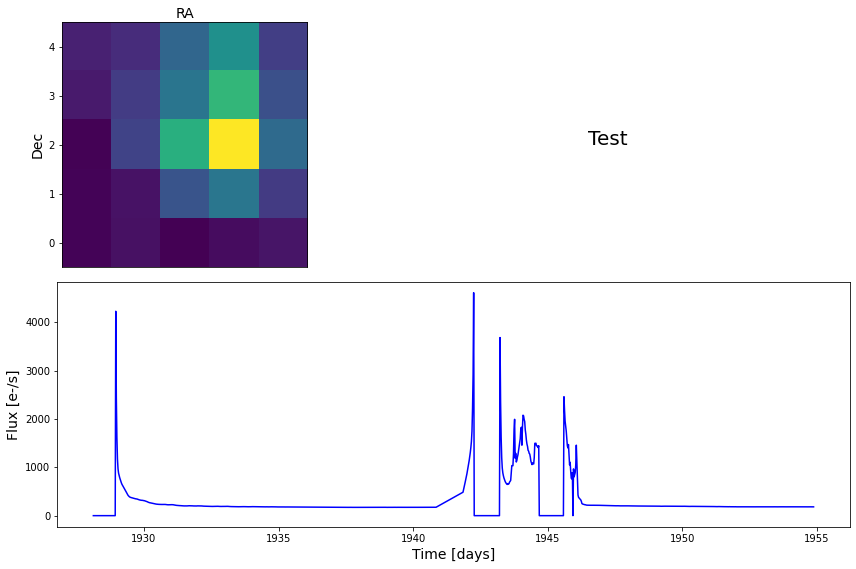

In [187]:
testfile = 'tess-s0023-1-4_204.642360_-2.265300_5x5_astrocut.fits'
#generate_lc_and_image(f'{mast_data_path}/{testfile}')
make_qa_plot(f'{mast_data_path}/{testfile}')

In [174]:
# this is one of the old files (1x1)

directory = '/Users/waderoemer/Desktop/MScThesis/astrocut_333'
file = 'tess-s0028-1-2_333.412570_-33.198980_1x1_astrocut.fits'
filepath = f'{directory}/{file}'
hdu = fits.open(filepath)
hdu.info()
hdu[1]

Filename: /Users/waderoemer/Desktop/MScThesis/astrocut_333/tess-s0028-1-2_333.412570_-33.198980_1x1_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  PIXELS        1 BinTableHDU    280   3464R x 12C   [D, E, J, 1J, 1E, 1E, 1E, 1E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        81   (1, 1)   int32   
